In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf  # Statsmodels is a Python module for statistics

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF 
from statsmodels.stats.anova import anova_lm

from ISLP import load_data    # ISLP library for the book, it has built in functions and methods to build models 
from ISLP.models import (ModelSpec as MS, summarize , poly) # It also has built-in data that can be loaded

import matplotlib as mpl


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'


sns.set(style="white") # Plot parameters defined globally
plt.style.use("seaborn-v0_8-white")

## *15) Regression with Boston dataset: predicting per capita crime rate*

In [2]:
df_boston = load_data('Boston')
df_boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


### For info on the data set: 

- https://islp.readthedocs.io/en/latest/datasets/Boston.html

In [3]:
df_boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


### a)

In [4]:
predictors = [col for col in df_boston.columns if col not in ['crim'] ] # list of predictors, recall that 'crim' is the response

res_dict = {'predictor': [], 'slr-coef': [], 'p-value': []}

fitted_response = []
for pred in predictors:
    
    result_fit = smf.ols(formula = f"crim ~ {pred}", data = df_boston).fit()
    
    coef = result_fit.params[1]
    
    pval = result_fit.pvalues[1]
    
    res_dict['predictor'].append(pred)
    
    res_dict['slr-coef'].append(coef)
    
    res_dict['p-value'].append(pval)

    fitted_response.append(result_fit.fittedvalues)

pval_table  = pd.DataFrame(res_dict)

print(pval_table)

   predictor   slr-coef       p-value
0         zn  -0.073935  5.506472e-06
1      indus   0.509776  1.450349e-21
2       chas  -1.892777  2.094345e-01
3        nox  31.248531  3.751739e-23
4         rm  -2.684051  6.346703e-07
5        age   0.107786  2.854869e-16
6        dis  -1.550902  8.519949e-19
7        rad   0.617911  2.693844e-56
8        tax   0.029742  2.357127e-47
9    ptratio   1.151983  2.942922e-11
10     lstat   0.548805  2.654277e-27
11      medv  -0.363160  1.173987e-19


### p-values indicate that all variables except chas has a relation with the the predictor crim. Lets make scatter plots together with the fit lines. 

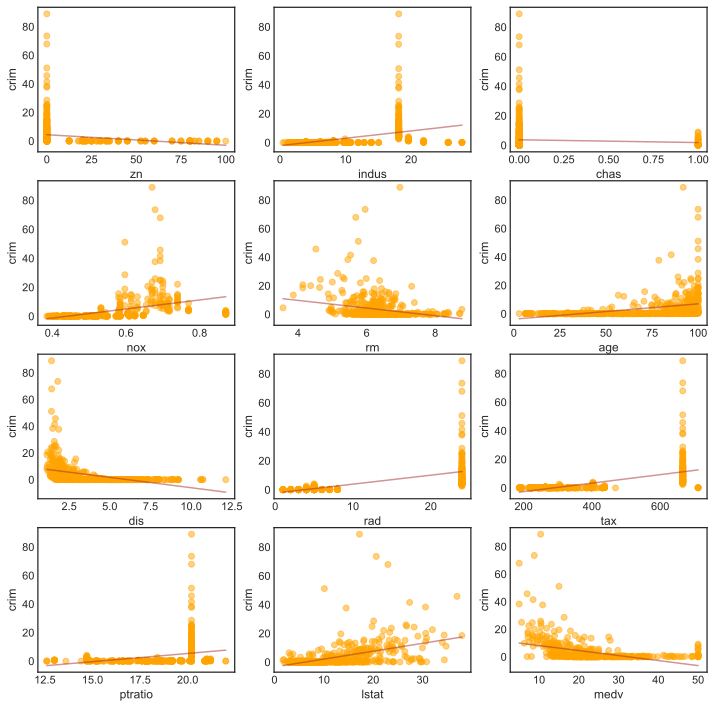

In [7]:
plt.figure(figsize = (12,12))

for index, pred in enumerate(predictors): # use enumerate to label each predictor with an index 0,..,11

    fit = smf.ols(formula = f"crim ~ {pred}", data = df_boston).fit()

    intercept = fit.params[0]
    slope = fit.params[1]

    plt.subplot(4,3,index+1) # 4 rows 3 columns, a total of 12 plots for each predictor


    plt.xlabel(f"{pred}")
    plt.ylabel('crim')


    plt.plot(df_boston[pred], intercept + slope * df_boston[pred], color = 'brown', alpha = 0.5)
    plt.scatter(df_boston[pred],df_boston['crim'], color = 'orange', alpha = 0.5)

### chas = 1 is a rare category, most of the instances occur at chas = 0. The linear relationship between many predictor - response pairs are also questionable. Non-linearities, outliers may be present.

In [8]:
print(f"The percentage of chas = 1 instances in the data is {((df_boston['chas'] == 1).sum() / len(df_boston)) * 100:.2f} percent")

The percentage of chas = 1 instances in the data is 6.92 percent


### b) 

In [9]:
model = "crim ~" + '+'.join([pred for pred in predictors])

MLR_FIT = smf.ols(model, data = df_boston).fit()

MLR_FIT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   crim   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     33.52
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           2.03e-56
Time:                        00:16:16   Log-Likelihood:                -1655.4
No. Observations:                 506   AIC:                             3337.
Df Residuals:                     493   BIC:                             3392.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.7784      7.082      1.946      0.052      -0.136      27.693
zn             0.0457      0.019      2.433      0.015       0.009       0.083
indus         -0.0584      0.084     -0.698      0.486      -0.223       0.106
chas          -0.8254      1.183     -0.697      0.486      -3.150       1.500
nox           -9.9576      5.290     -1.882      0.060     -20.351       0.436
rm             0.6289      0.607      1.036      0.301      -0.564       1.822
age           -0.0008      0.018     -0.047      0.962      -0.036       0.034
dis           -1.0122      0.282     -3.584      0.000      -1.567      -0.457
rad            0.6125      0.088      6.997      0.000       0.440       0.784
tax           -0.0038      0.005     -0.730      0.466      -0.014       0.006
ptratio       -0.3041      0.186     -1.632      0.103      -0.670       0.062
lstat          0.1388      0.076      1.833      0.067      -0.010       0.288
medv          -0.2201      0.060     -3.678      0.000      -0.338      -0.103
==============================================================================
Omnibus:                      663.436   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80856.852
Skew:                           6.579   Prob(JB):                         0.00
Kurtosis:                      63.514   Cond. No.                     1.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### At 5 % (p = 0.05) level, we can not reject the null hypothesis for all the predictors except zn, dis, rad, medv. At 1 % (p = 0.01), only dis, rad, medv shows statistically significant relationship with the response. 

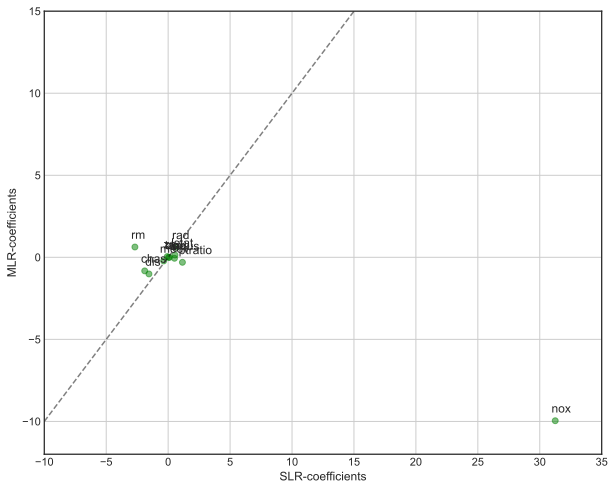

In [10]:
mlr_coeffs = [MLR_FIT.params[1:][i] for i in range(12)]
slr_coeffs = [pval_table['slr-coef'][i] for i in range(12)]
fig, axes = plt.subplots(figsize = (10,8))

axes.set_xlim(-10,35)
axes.set_ylim(-12,15)

axes.set_xlabel('SLR-coefficients')

axes.set_ylabel('MLR-coefficients')

axes.grid()

for index, pred in enumerate(pval_table['predictor']):
    axes.annotate(pred, xy = (pval_table['slr-coef'][index]-0.3,MLR_FIT.params[1:][index]+0.5))

axes.scatter(slr_coeffs, mlr_coeffs, color = 'green', alpha = 0.5)
axes.plot([-10,15],[-10,15], color = 'black', alpha = 0.5, ls = 'dashed')

### Lets ignore nox as it appears as an 'outlier' in thee plot above.  

In [12]:
MLR_FIT.params[1:]

zn         0.045710
indus     -0.058350
chas      -0.825378
nox       -9.957587
rm         0.628911
age       -0.000848
dis       -1.012247
rad        0.612465
tax       -0.003776
ptratio   -0.304073
lstat      0.138801
medv      -0.220056
dtype: float64

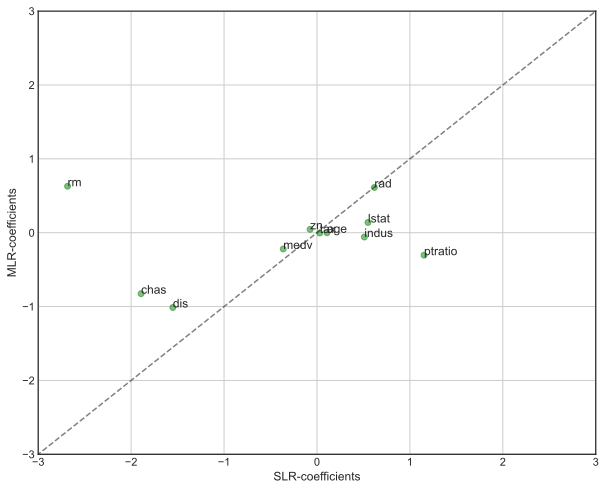

In [13]:
mlr_coeffsa = [MLR_FIT.params[1:][i] for i in range(12) if i != 3] #index of nox is 3
slr_coeffsa = [pval_table['slr-coef'][i] for i in range(12) if i != 3]
fig, axes = plt.subplots(figsize = (10,8))

axes.set_xlim(-3,3)
axes.set_ylim(-3,3)

axes.set_xlabel('SLR-coefficients')

axes.set_ylabel('MLR-coefficients')

axes.grid()

for index, pred in enumerate(pval_table['predictor']):
    if index != 3:
        axes.annotate(pred, xy = (pval_table['slr-coef'][index],MLR_FIT.params[1:][index]))

axes.scatter(slr_coeffsa, mlr_coeffsa, color = 'green', alpha = 0.5)
axes.plot([-10,15],[-10,15], color = 'black', alpha = 0.5, ls = 'dashed')

In [14]:
ceoff_table = pd.DataFrame({'Predictors': predictors, 'SLR_coeff': slr_coeffs, 'MLR_coeff': mlr_coeffs})

ceoff_table

,Predictors,SLR_coeff,MLR_coeff
0,zn,-0.073935,0.045710
1,indus,0.509776,-0.058350
2,chas,-1.892777,-0.825378
3,nox,31.248531,-9.957587
4,rm,-2.684051,0.628911
5,age,0.107786,-0.000848
6,dis,-1.550902,-1.012247
7,rad,0.617911,0.612465
8,tax,0.029742,-0.003776
9,ptratio,1.151983,-0.304073


### Looking at the plots and the table above, coefficient values of some predictors did not change much: rad, zn, medv. In particular rad does not exhibit much change, implying that it does not exhibit multi-collinearity with another predictor. 

### Interpretation of the coefficients in the simple linear regression with all predictors vs multiple linear regression is quite different. In the simple linear regression each coefficients indicate the average change in the response by a unit change of the predictor while we ignore all the other attribures whereas in the multiple regression setting each coefficient is an indicator of the change in the response while we keep aşş the other features constant. Due to possibility of (multi)collinearity, we expect the coefficients of these approaches to differ on general grounds. 

### d) Lets first make fitted values vs residuals plot to see if there is a discernable pattern 

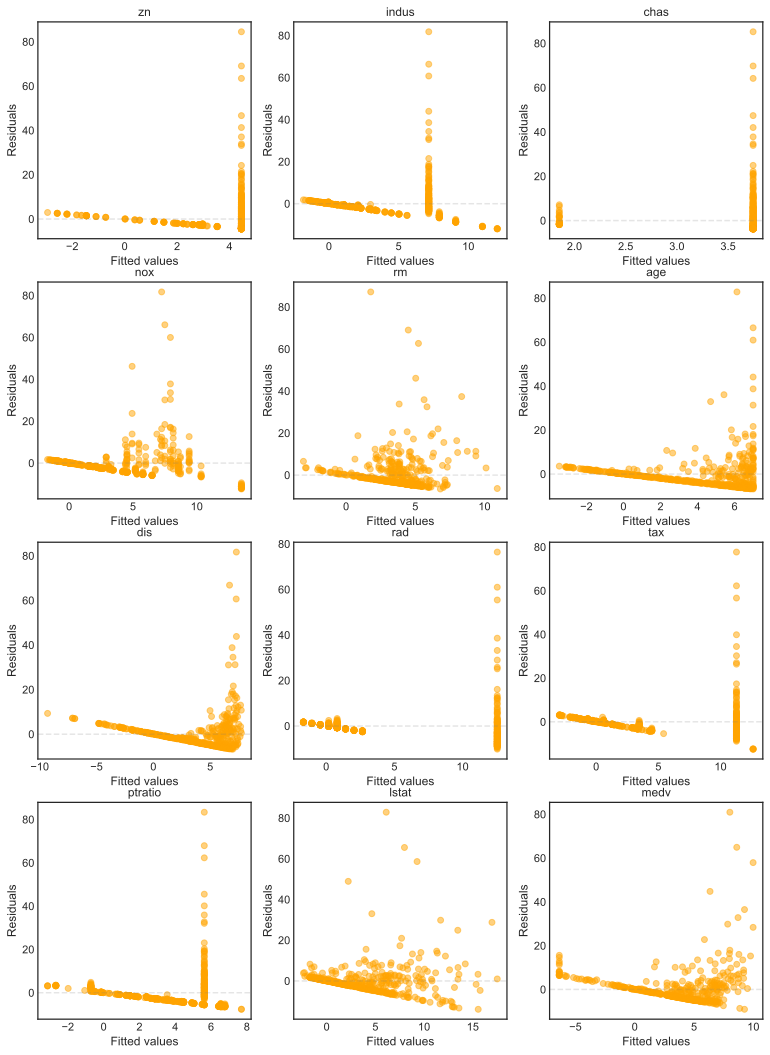

In [22]:
plt.figure(figsize = (13,18))

for index, pred in enumerate(predictors): # use enumerate to label each predictor with an index 0,..,11

    fit = smf.ols(formula = f"crim ~ {pred}", data = df_boston).fit()

    intercept = fit.params[0]
    slope = fit.params[1]

    plt.subplot(4,3,index+1) # 4 rows 3 columns, a total of 12 plots for each predictor

    plt.axhline(0, color = 'gray', ls = 'dashed', alpha = 0.2)
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f"{pred}")
   

    plt.scatter(fit.fittedvalues,fit.resid, color = 'orange', alpha = 0.5)

In [25]:
res_dict = {'predictor': [], 'beta_1': [], 'beta_2': [], 'beta_3': []}

for pred in predictors:
    
    result_fit = smf.ols(formula = f"crim ~ {pred} + np.power({pred},2) + np.power({pred},3)", data = df_boston).fit()
    
   
    beta1 = round(result_fit.params[1],5)
    beta2 = round(result_fit.params[2],5)
    beta3 = round(result_fit.params[3],5)
    
    pval1 = round(result_fit.pvalues[1],5)
    pval2 = round(result_fit.pvalues[2],5)
    pval3 = round(result_fit.pvalues[3],5)
    
    res_dict['predictor'].append(pred)
    
    res_dict['beta_1'].append((beta1,pval1)) # append the coefficient and its p-value as a tuple to the dictionary
    
    res_dict['beta_2'].append((beta2,pval2))

    res_dict['beta_3'].append((beta3,pval3))


NL_result_table  = pd.DataFrame(res_dict)

print(NL_result_table)

   predictor                beta_1               beta_2               beta_3
0         zn   (-0.33219, 0.00261)   (0.00648, 0.09375)    (-4e-05, 0.22954)
1      indus     (-1.96521, 5e-05)       (0.25194, 0.0)      (-0.00698, 0.0)
2       chas   (-0.63093, 0.20943)  (-0.63093, 0.20943)  (-0.63093, 0.20943)
3        nox    (-1279.37125, 0.0)    (2248.54405, 0.0)   (-1245.70287, 0.0)
4         rm  (-39.15014, 0.21176)    (4.5509, 0.36411)  (-0.17448, 0.50858)
5        age    (0.27365, 0.14266)  (-0.00723, 0.04738)     (6e-05, 0.00668)
6        dis      (-15.55435, 0.0)       (2.45207, 0.0)       (-0.1186, 0.0)
7        rad    (0.51274, 0.62342)  (-0.07518, 0.61301)   (0.00321, 0.48231)
8        tax   (-0.15331, 0.10971)   (0.00036, 0.13747)      (-0.0, 0.24385)
9    ptratio  (-82.36054, 0.00303)   (4.63535, 0.00412)   (-0.08476, 0.0063)
10     lstat   (-0.44907, 0.33453)   (0.05578, 0.06459)  (-0.00086, 0.12989)
11      medv       (-5.09483, 0.0)        (0.1555, 0.0)      (-0.00149, 0.0)

### The table tells us with 95% confidence, there is evidence for non-linearity associated between the following predictors: indus,nox,age,dis,ptratio, medv and the response. 

### These results can be supported visually from the residuals vs fitted values results we obtained earlier which is obtained through simple linear regression between each predictor and the response. 